# Housing Example Project

In [116]:
# Pydata stack
import numpy as np
import pandas as pd

# Plotting
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

# Scikit-Learn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit # To create test set
from sklearn.impute import SimpleImputer # To deal with missing values
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder # Turn categorical into numerical
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Feature scaling
from sklearn.base import BaseEstimator, TransformerMixin # To create custom transformers
from sklearn.pipeline import Pipeline, make_pipeline # Pipelines to chain estimators
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector # To do estimators in parallel

from sklearn import set_config # Displays HTML representation of composite estimators
set_config(display='diagram')   


# For OS dependent functionality
import os

# For tgz files
import tarfile

# To download data from url
import urllib.request

### Download the Data

Begin with functions to download and load data. Usually these would be saved in a script.

In [2]:
# Note capitals for constants
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Function to retrieve data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# Call function to download data
fetch_housing_data()

In [3]:
# Function to load data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


housing = load_housing_data()

### Quick Look

First look at the data

In [4]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

/Users/christopherleonard/P/hands-on-machine-learning/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


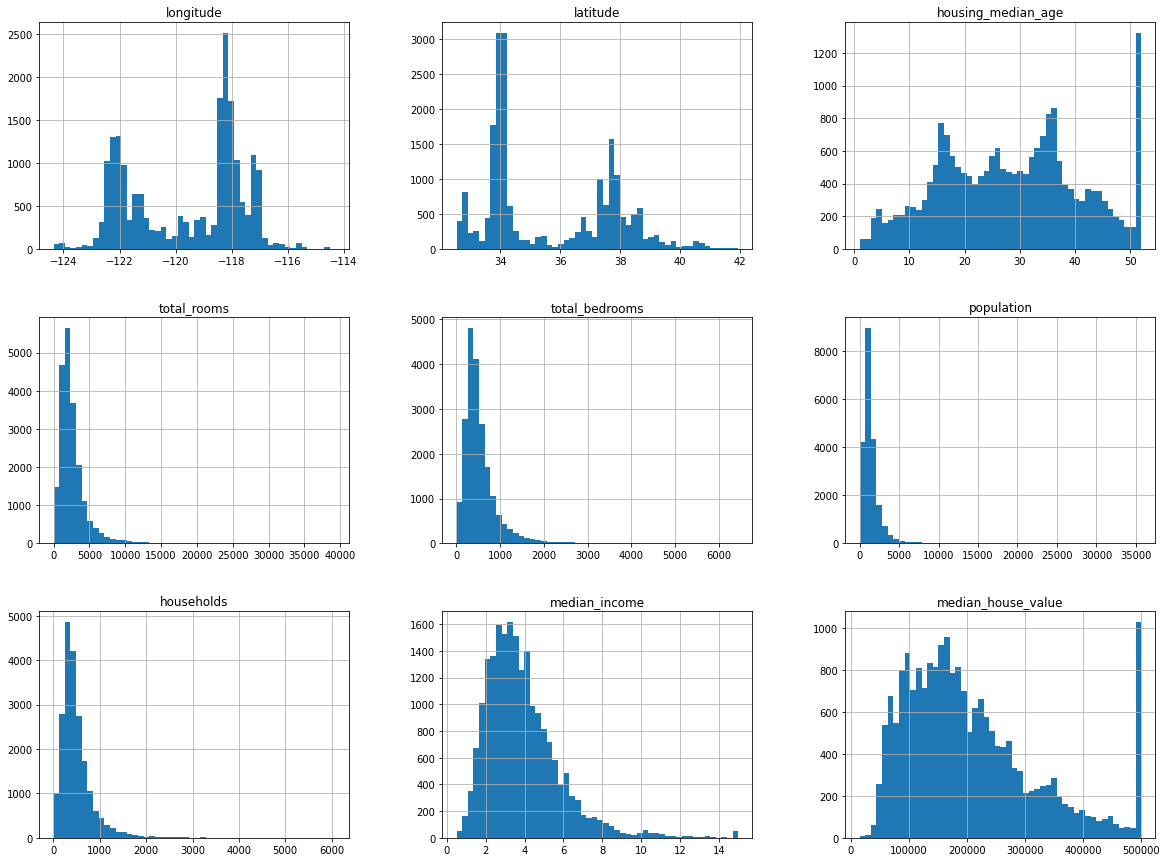

In [8]:
# Histogram of each numerical attribute
housing.hist(bins=50, figsize=(20,15));

### Create a Test Set

In [9]:
# Basic 80/20 split
# Random state ensures that same split can be replicated
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

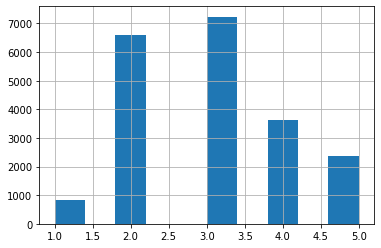

In [10]:
# Turning median income from continuous to categorical variable
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

housing['income_cat'].hist();

In [11]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Note this loop has only one iteration
# Syntax is necessary because of split class
# Makes more sense when n_splits > 1
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
def income_cat_dist(df):
    print(df['income_cat'].value_counts() / len(df))

for df in [housing, strat_train_set, strat_test_set]:
    income_cat_dist(df)
    print('\n')

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64




In [14]:
# Remove income_cat
for df in [strat_train_set, strat_test_set]:
    df.drop('income_cat', axis=1, inplace=True)

### Visualise Geographical Data

In [15]:
# Duplicate training set
housing = strat_train_set.copy()

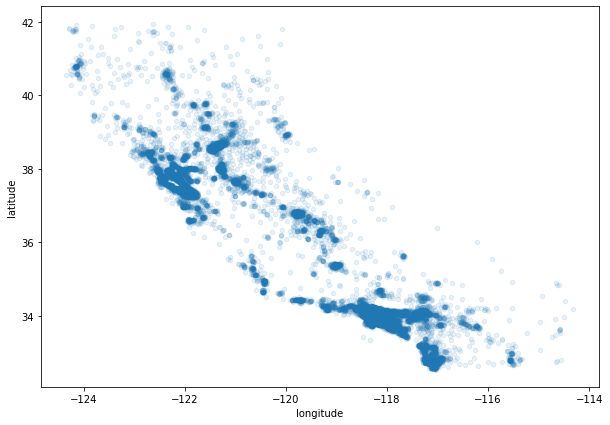

In [16]:
# Scatter plot of coordinates of districts
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, figsize=(10,7));

/Users/christopherleonard/P/hands-on-machine-learning/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


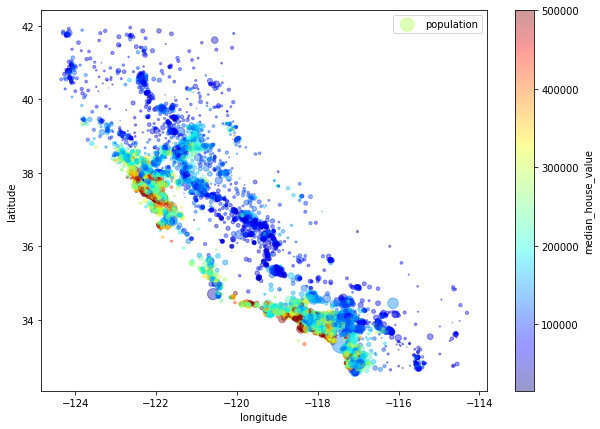

In [17]:
# 
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housing['population']/100, # Size of circles, over 100 for scaling
    label='population',
    c='median_house_value',
    cmap=plt.get_cmap('jet'), # Predefined colour map from blue to red - a good default
    colorbar=True, # Key for colours
    figsize=(10, 7),
    sharex=False # Fig bug with x-ticks and label not appearing
);

### Finding Correlations

In [18]:
# Calculate correlation matrix
corr_matrix = housing.corr()

In [19]:
# Concentrate on median house value as this is what we want to predict
corr_matrix['median_house_value'].sort_values(ascending=False).round(2)

median_house_value    1.00
median_income         0.69
total_rooms           0.14
housing_median_age    0.11
households            0.06
total_bedrooms        0.05
population           -0.03
longitude            -0.05
latitude             -0.14
Name: median_house_value, dtype: float64

In [20]:
# Find the greatest correlations between features - might be good to remove highly correlated features
abs_corr_matrix = np.abs(corr_matrix)
max_corr = abs_corr_matrix[abs_corr_matrix != 1].stack().nlargest(10)
max_corr_feat = sorted(list({pair[0] for pair in max_corr.index}))

print('Features with the greatest correlations:')
corr_matrix.loc[max_corr_feat, max_corr_feat].round(2)

Features with the greatest correlations:


,households,latitude,longitude,population,total_bedrooms,total_rooms
households,1.00,-0.08,0.06,0.90,0.98,0.92
latitude,-0.08,1.00,-0.92,-0.12,-0.07,-0.04
longitude,0.06,-0.92,1.00,0.11,0.08,0.05
population,0.90,-0.12,0.11,1.00,0.88,0.86
total_bedrooms,0.98,-0.07,0.08,0.88,1.00,0.93
total_rooms,0.92,-0.04,0.05,0.86,0.93,1.00


/Users/christopherleonard/P/hands-on-machine-learning/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


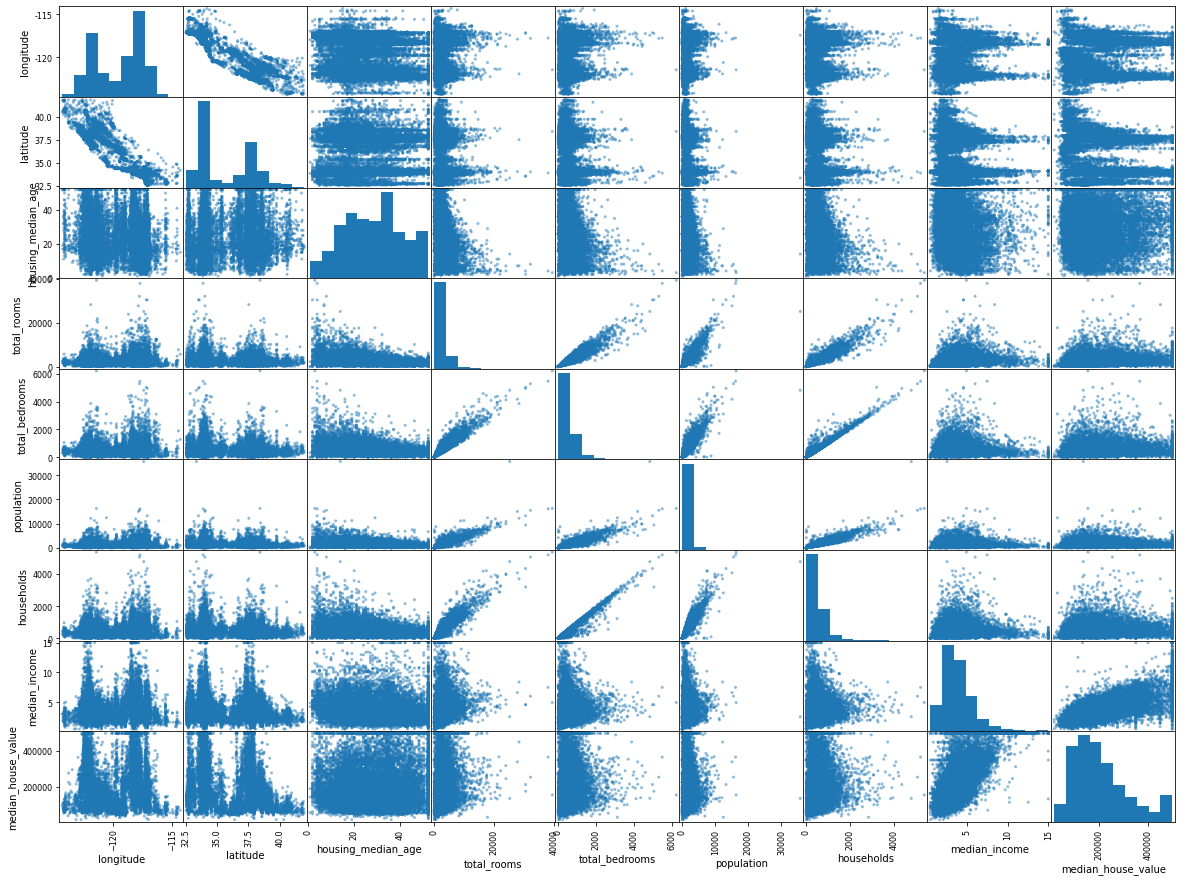

In [21]:
# Scatter matrix of attributes
scatter_matrix(housing, figsize=(20, 15));

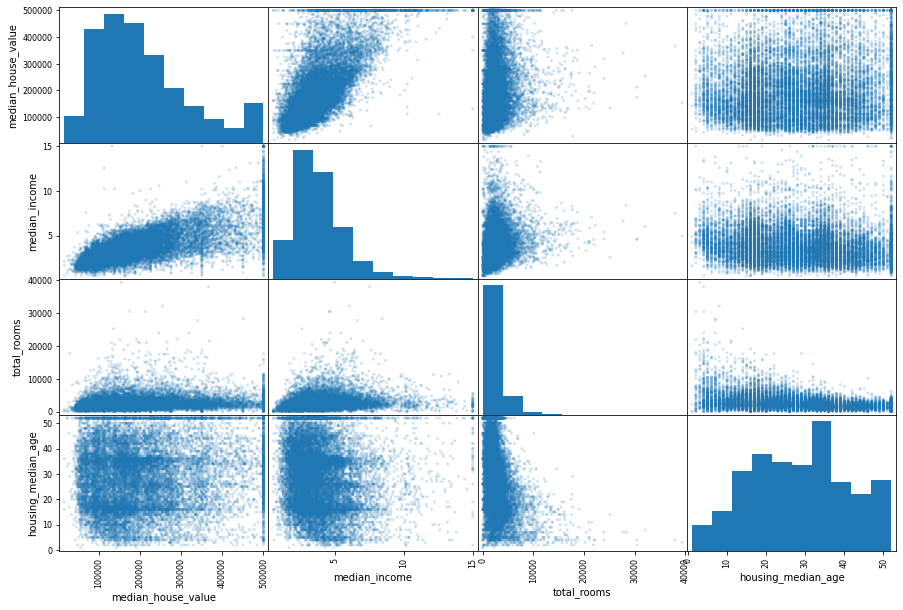

In [22]:
# Can be better to concentrate on a few attributes
attributes = [
    'median_house_value',
    'median_income',
    'total_rooms',
    'housing_median_age'
]
scatter_matrix(housing[attributes], alpha=0.2, figsize=(15, 10));

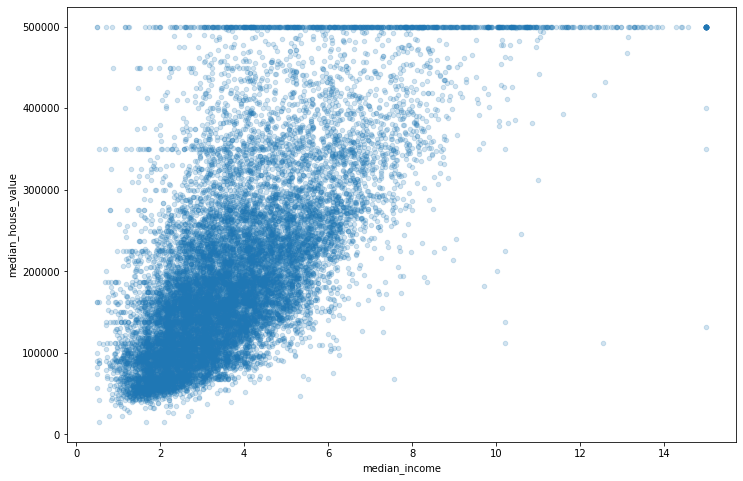

In [23]:
# Focus on median income and median house value
housing.plot(
    kind='scatter',
    x='median_income',
    y='median_house_value',
    alpha=0.2,
    figsize=(12, 8)
);

In [24]:
# Try creating some new features from old
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

# Take another look at correlation
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare Data for Machine Learning

In [25]:
# Get a clean copy of training set and separate into inputs and outputs
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

In [26]:
# Resolve missing values by imputing the median

# df of numerical inputs
housing_num = housing.drop('ocean_proximity', axis=1)

# Instantiate estimator
imputer = SimpleImputer(strategy='median')

# Fit to training data
imputer.fit(housing_num)

# View medians
pd.DataFrame(
    np.r_['0,2', imputer.statistics_], # learned parameters always have underscore suffix
    columns=housing_num.columns
) 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-118.51,34.26,29.0,2119.5,433.0,1164.0,408.0,3.5409


In [27]:
# Use trained estimator
X = imputer.transform(housing_num) # Output is Numpy array
housing_tr = pd.DataFrame(
    X,
    columns=housing_num.columns,
    index=housing_num.index
)

### Handling Categorical Attributes

In [28]:
# Categorical features
housing_cat = housing[['ocean_proximity']]

In [29]:
# Enumerate categories
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [30]:
# Display encoding
pd.DataFrame(ordinal_encoder.categories_[0])

,0
0,<1H OCEAN
1,INLAND
2,ISLAND
3,NEAR BAY
4,NEAR OCEAN


In [31]:
# Using one-hot encoding (encodes each possibility as a binary variable)
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) # Output has class SparseMatrix
housing_cat_1hot.toarray()[:5, :]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [32]:
# Show encoding
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [33]:
# Can also drop a single category to avoid colinearity
cat_encoder_drop = OneHotEncoder(drop='first')
housing_cat_1hot_drop = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot_drop.toarray()[:5, :]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

### Custom Transformers

In [34]:
# Create a transformer to add extra 'combined' features

# Column indices - seems you want to input and output numpy arrays
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# BaseEstimator base gives you get_params() and set_params() methods
# TransformerMixin gives you fit_transform() method
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kwargs, else BaseEstimator doesn't work
        self.add_bedrooms_per_room = add_bedrooms_per_room # arguments when instantiating class 
        
    def fit(self, X, y=None):       
        return self  # must return self to fit with TransformerMixin
    
    def transform(self, X):   
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [35]:
# Testing
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)

X = attr_adder.fit_transform(housing.values)
housing_extra_attribs = pd.DataFrame(
    X,
    columns=list(housing.columns)+['rooms_per_household', 'population_per_household', 'bedrooms_per_room'],
    index=housing.index
)

housing_extra_attribs.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395,0.223852
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965,0.159057
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974,0.241291
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977,0.200866
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847,0.231341


In [36]:
# Method from parents BaseEstimator
attr_adder.get_params()

{'add_bedrooms_per_room': True}

###  Feature Scaling

In [47]:
# Min max scaling on numerical data
scaler = MinMaxScaler()
scaler.fit(housing_num)

# Print some of the data
pd.DataFrame(
    np.c_[scaler.data_min_, scaler.data_max_, scaler.data_range_],
    columns=['min', 'max', 'range'],
    index=housing_num.columns
)

,min,max,range
longitude,-124.3500,-114.3100,10.0400
latitude,32.5400,41.9500,9.4100
housing_median_age,1.0000,52.0000,51.0000
total_rooms,6.0000,39320.0000,39314.0000
total_bedrooms,2.0000,6210.0000,6208.0000
population,3.0000,35682.0000,35679.0000
households,2.0000,5358.0000,5356.0000
median_income,0.4999,15.0001,14.5002


In [80]:
# Scaled data
housing_num_scaled = pd.DataFrame(
    scaler.transform(housing_num),
    columns=housing_num.columns,
    index=housing_num.index
)

housing_num_scaled.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,0.245020,0.504782,0.725490,0.039731,0.056218,0.019816,0.062920,0.152019
18632,0.241036,0.479277,0.254902,0.017119,0.017075,0.008492,0.020724,0.408374
14650,0.712151,0.024442,0.588235,0.049499,0.075548,0.026150,0.085885,0.162908
3230,0.472112,0.400638,0.470588,0.046828,0.059439,0.040836,0.065534,0.095447
3555,0.573705,0.179596,0.313725,0.167523,0.245329,0.124891,0.272778,0.174811


In [78]:
# Now try standardisation
standard_scaler = StandardScaler()
standard_scaler.fit(housing_num)

# Transform and print new mean and stdev
housing_num_std = pd.DataFrame(
    standard_scaler.transform(housing_num),
    columns=housing_num.columns,
    index=housing_num.index
)
pd.DataFrame(
    np.c_[housing_num_std.mean(axis=0, skipna=True), housing_num_std.std(axis=0, skipna=True)],
    columns=['mean', 'std'],
    index=housing_num.columns
).round(3)

,mean,std
longitude,-0.0,1.0
latitude,0.0,1.0
housing_median_age,-0.0,1.0
total_rooms,0.0,1.0
total_bedrooms,0.0,1.0
population,-0.0,1.0
households,0.0,1.0
median_income,-0.0,1.0


### Transformation Pipelines

In [85]:
# Create pipeline for numerical inputs
estimators = [
    ('imputer', SimpleImputer(strategy="median")), # (name, estimator) pairs
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
]
num_pipeline = Pipeline(estimators)

In [98]:
# List of estimators
num_pipeline.steps

[('imputer', SimpleImputer(strategy='median')),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler())]

In [99]:
# Access constituent estimaters using index
num_pipeline[0]

SimpleImputer(strategy='median')

In [101]:
# ...or label
num_pipeline['attribs_adder']

CombinedAttributesAdder()

In [102]:
# Params are labelled using syntax estimator__param
num_pipeline.get_params()

{'memory': None,
 'steps': [('imputer', SimpleImputer(strategy='median')),
  ('attribs_adder', CombinedAttributesAdder()),
  ('std_scaler', StandardScaler())],
 'verbose': False,
 'imputer': SimpleImputer(strategy='median'),
 'attribs_adder': CombinedAttributesAdder(),
 'std_scaler': StandardScaler(),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__missing_values': nan,
 'imputer__strategy': 'median',
 'imputer__verbose': 0,
 'attribs_adder__add_bedrooms_per_room': True,
 'std_scaler__copy': True,
 'std_scaler__with_mean': True,
 'std_scaler__with_std': True}

In [103]:
# make_pipeline is shorthand for Pipeline with labels generated automatically
make_pipeline(SimpleImputer(strategy="median"), CombinedAttributesAdder(), StandardScaler())

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('combinedattributesadder', CombinedAttributesAdder()),
                ('standardscaler', StandardScaler())])

In [106]:
# Fitting pipeline does fit_transform on all estimators up to last where it fits
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr[:5, :]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314],
       [ 0.49247384, -0.65929936, -0.92673619,  1.85619316,  2.41221109,
         2.72415407,  2.57097492, -0.44143679, -0.35783383, -0.00419445,
         0.2699277 ]])

In [108]:
# Apply different transformers to numerical and categorical features
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs), # Triple (name, transformer, column labels)
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [109]:
# Display diagram of composite estimator
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(), ['ocean_proximity'])])

In [122]:
# Can select columns by datatype using make_column_selector
trans = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include='float64')),
    (OneHotEncoder(), make_column_selector(dtype_include='object'))
)

np.array_equal(trans.fit_transform(housing), housing_prepared)

True